<a href="https://colab.research.google.com/github/Lanxin-Xiang/is765/blob/main/W6_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W6. Text Clustering

Ref:

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

https://scikit-learn.org/stable/modules/clustering.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive') #, force_remount=True)

## Prepare data

### Load data

We load data from The 20 newsgroups text dataset, which comprises around 18,000 newsgroups posts on 20 topics. For illustrative purposes and to reduce the computational cost, we select a subset of 4 topics only accounting for around 3,400 documents.

Notice that, by default, the text samples contain some message metadata such as "headers", "footers" (signatures) and "quotes" to other posts. We use the remove parameter from fetch_20newsgroups to strip those features and have a more sensible clustering problem.

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

In [ ]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


### Text representation

Here, we provide the TF-IDF code for text representation. However, you can choose any text embedding methods as you like.


Here is an article talking about how to train and use [Doc2Vec](https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5).

#### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import pandas as pd

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 1.337 s
n_samples: 3387, n_features: 7929


In [ ]:
# How to transform the metrix to pandas dataframe
feature_names = vectorizer.get_feature_names_out()
dense = X_tfidf.todense()
lst = dense.tolist()
df = pd.DataFrame(lst, columns=feature_names)

In the following examples, we are going to evaluate the performance of each methods with [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). We are expecting higher silhoutte score, which stands for better performance.

## Cluster with K-Means

### Clustering sparse data with k-means

Before dimension reduction, the tf-idf metrix is sparse in high dimensional space.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    score = silhouette_score(X_tfidf, kmeans.labels_)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}; Silhouette Coefficient: {score}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [   1    1 3384    1]; Silhouette Coefficient: -0.0016000709972601342
Number of elements assigned to each cluster: [1597  732  233  825]; Silhouette Coefficient: 0.00677296938207601
Number of elements assigned to each cluster: [2004  446  646  291]; Silhouette Coefficient: 0.008270510550457265
Number of elements assigned to each cluster: [1695  649  446  597]; Silhouette Coefficient: 0.0068750019976936945
Number of elements assigned to each cluster: [ 254 2117  459  557]; Silhouette Coefficient: 0.009099362458194215

True number of documents in each category according to the class labels: [799 973 987 628]


To avoid this problem, one possibility is to increase the number of runs with independent random initiations `n_init`. In such case the clustering with the best inertia (objective function of k-means) is chosen.

In [ ]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    score = silhouette_score(X_tfidf, kmeans.labels_)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}; Silhouette Coefficient: {score}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [1781  659  489  458]; Silhouette Coefficient: 0.007267274158819583
Number of elements assigned to each cluster: [  24  519 2098  746]; Silhouette Coefficient: 0.009981723722528911
Number of elements assigned to each cluster: [ 448  448 1770  721]; Silhouette Coefficient: 0.007092042506153303
Number of elements assigned to each cluster: [1695  649  446  597]; Silhouette Coefficient: 0.0068750019976936945
Number of elements assigned to each cluster: [ 364  477  664 1882]; Silhouette Coefficient: 0.007855390302908227

True number of documents in each category according to the class labels: [799 973 987 628]


### Performing dimensionality reduction using LSA

LSA is a common topic modeling methods and also a classic dimension reduction method in the context of text data analysis. We are going to talk more about it in a few weeks, but the core idea is to apply SVD to the words metrix.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [ ]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 1.003 s
Explained variance of the SVD step: 18.4%


After the LSA step, the metrix is reduced to 3387 rows and only 100 columns now.

In [ ]:
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_lsa)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    score = silhouette_score(X_lsa, kmeans.labels_)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}; Silhouette Coefficient: {score}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [1632  554  915  286]; Silhouette Coefficient: 0.030024352357602042
Number of elements assigned to each cluster: [ 920 1626  257  584]; Silhouette Coefficient: 0.03041871124908024
Number of elements assigned to each cluster: [ 560  908  286 1633]; Silhouette Coefficient: 0.03010015662540649
Number of elements assigned to each cluster: [ 909  549 1636  293]; Silhouette Coefficient: 0.0300420793507377
Number of elements assigned to each cluster: [ 551  293  907 1636]; Silhouette Coefficient: 0.030054343288672222

True number of documents in each category according to the class labels: [799 973 987 628]


### The elbow method to find best number of clusters

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

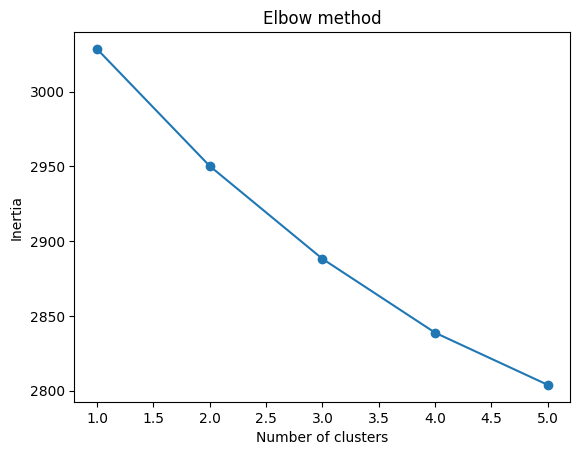

In [ ]:
inertias = []

for i in range(1,6):
    kmeans = KMeans(n_clusters=i,n_init=5,max_iter=100,random_state=2)
    kmeans.fit(X_lsa)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,6), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

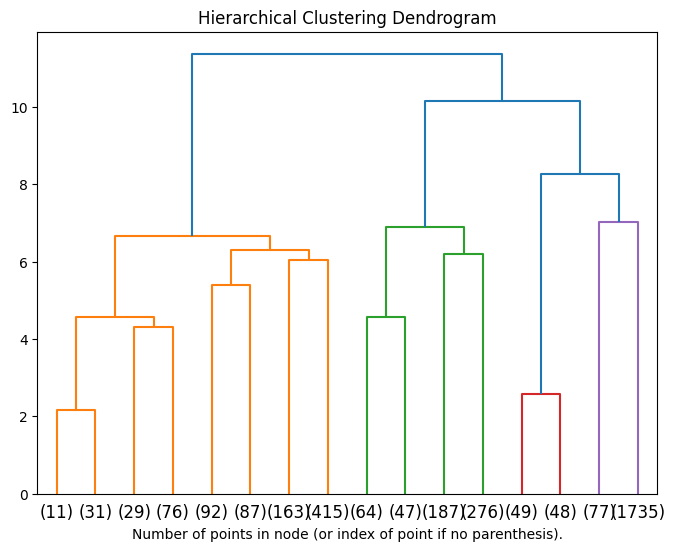

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hierarchical_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = hierarchical_model.fit(X_lsa)

plt.figure(figsize=(8,6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Find out the parameters that produce the best Silhouette coefficient score

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def find_best_score(data, parameterGrid, model):
  res = []
  best_score = -1
  best_params = {}
  best_label = []

  for params in ParameterGrid(param_grid):
    try:
      clustering = model(**params)
      labels = clustering.fit_predict(data)
      print(params)

      score = silhouette_score(data, labels)
      res.append(list(params.values())+[score])
      if score > best_score:
        best_score = score
        best_params = params
        best_label = labels
    except:
      continue

  print("Best Parameters:", best_params)
  return(best_score, best_params, best_label, res)

In [ ]:
# note: if using ward linkage, only euclidean metric applys

param_grid = {'linkage': ["ward", "average", "complete", "single"],
              'metric':['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'],
              'n_clusters': list(range(2, 6))}
parameterGrid = ParameterGrid(param_grid)

In [ ]:
best_score, best_params, best_label, scores = find_best_score(X_lsa, parameterGrid, AgglomerativeClustering)

{'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
{'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 3}
{'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 4}
{'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 5}
{'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 2}
{'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 3}
{'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 4}
{'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 5}
{'linkage': 'average', 'metric': 'l1', 'n_clusters': 2}
{'linkage': 'average', 'metric': 'l1', 'n_clusters': 3}
{'linkage': 'average', 'metric': 'l1', 'n_clusters': 4}
{'linkage': 'average', 'metric': 'l1', 'n_clusters': 5}
{'linkage': 'average', 'metric': 'l2', 'n_clusters': 2}
{'linkage': 'average', 'metric': 'l2', 'n_clusters': 3}
{'linkage': 'average', 'metric': 'l2', 'n_clusters': 4}
{'linkage': 'average', 'metric': 'l2', 'n_clusters': 5}
{'linkage': 'average', 'metric': 'manhattan', 'n_clusters': 

In [ ]:
scores_pd = pd.DataFrame(scores, columns=['linkage', 'metric', 'n_cluster', 'score'])

In [ ]:
n_tested_clusters = 4

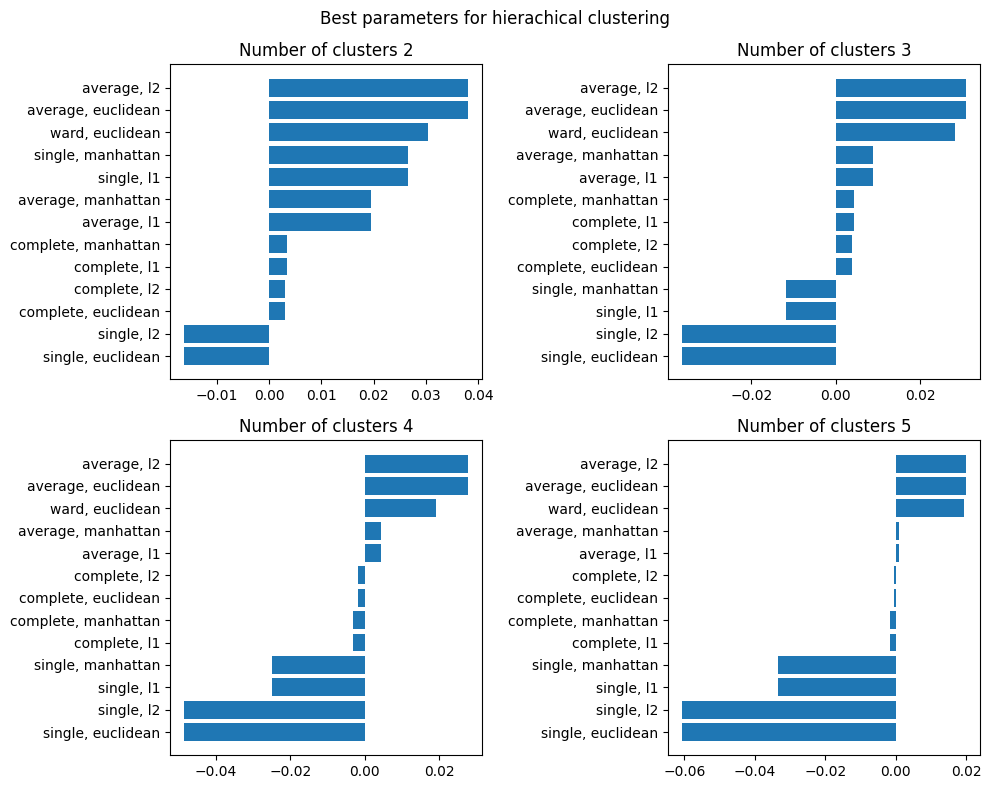

In [ ]:
fig, axes = plt.subplots(n_tested_clusters//2, 2, figsize=(10, 8))

for i in range(n_tested_clusters):
  subscore = scores_pd[scores_pd['n_cluster'] == i+2].sort_values(by='score')
  plt.subplot(n_tested_clusters//2, 2, i+1)
  plt.barh(subscore['linkage'] + ", " +subscore['metric'], subscore['score'])
  # plt.axis("off")
  plt.title(f'Number of clusters {i+2}')

fig.suptitle("Best parameters for hierachical clustering")
plt.tight_layout()
plt.show()

In [ ]:
clustering = AgglomerativeClustering(**best_params)
labels = clustering.fit_predict(X_lsa)

## Other Cluster Methods

Read more about other cluster methods [here](https://scikit-learn.org/stable/modules/clustering.html#). Pay attention to the parameters!

In [ ]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039172 sha256=2b3305247ac15f8ef02e0753398957b992e43715c7f559fbb5887bb7f1b1eb86
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.4
    Uninstalling Cython-3.0.4:
      Successfully uninstalled Cython-3.0.4


In [ ]:
from hdbscan import HDBSCAN

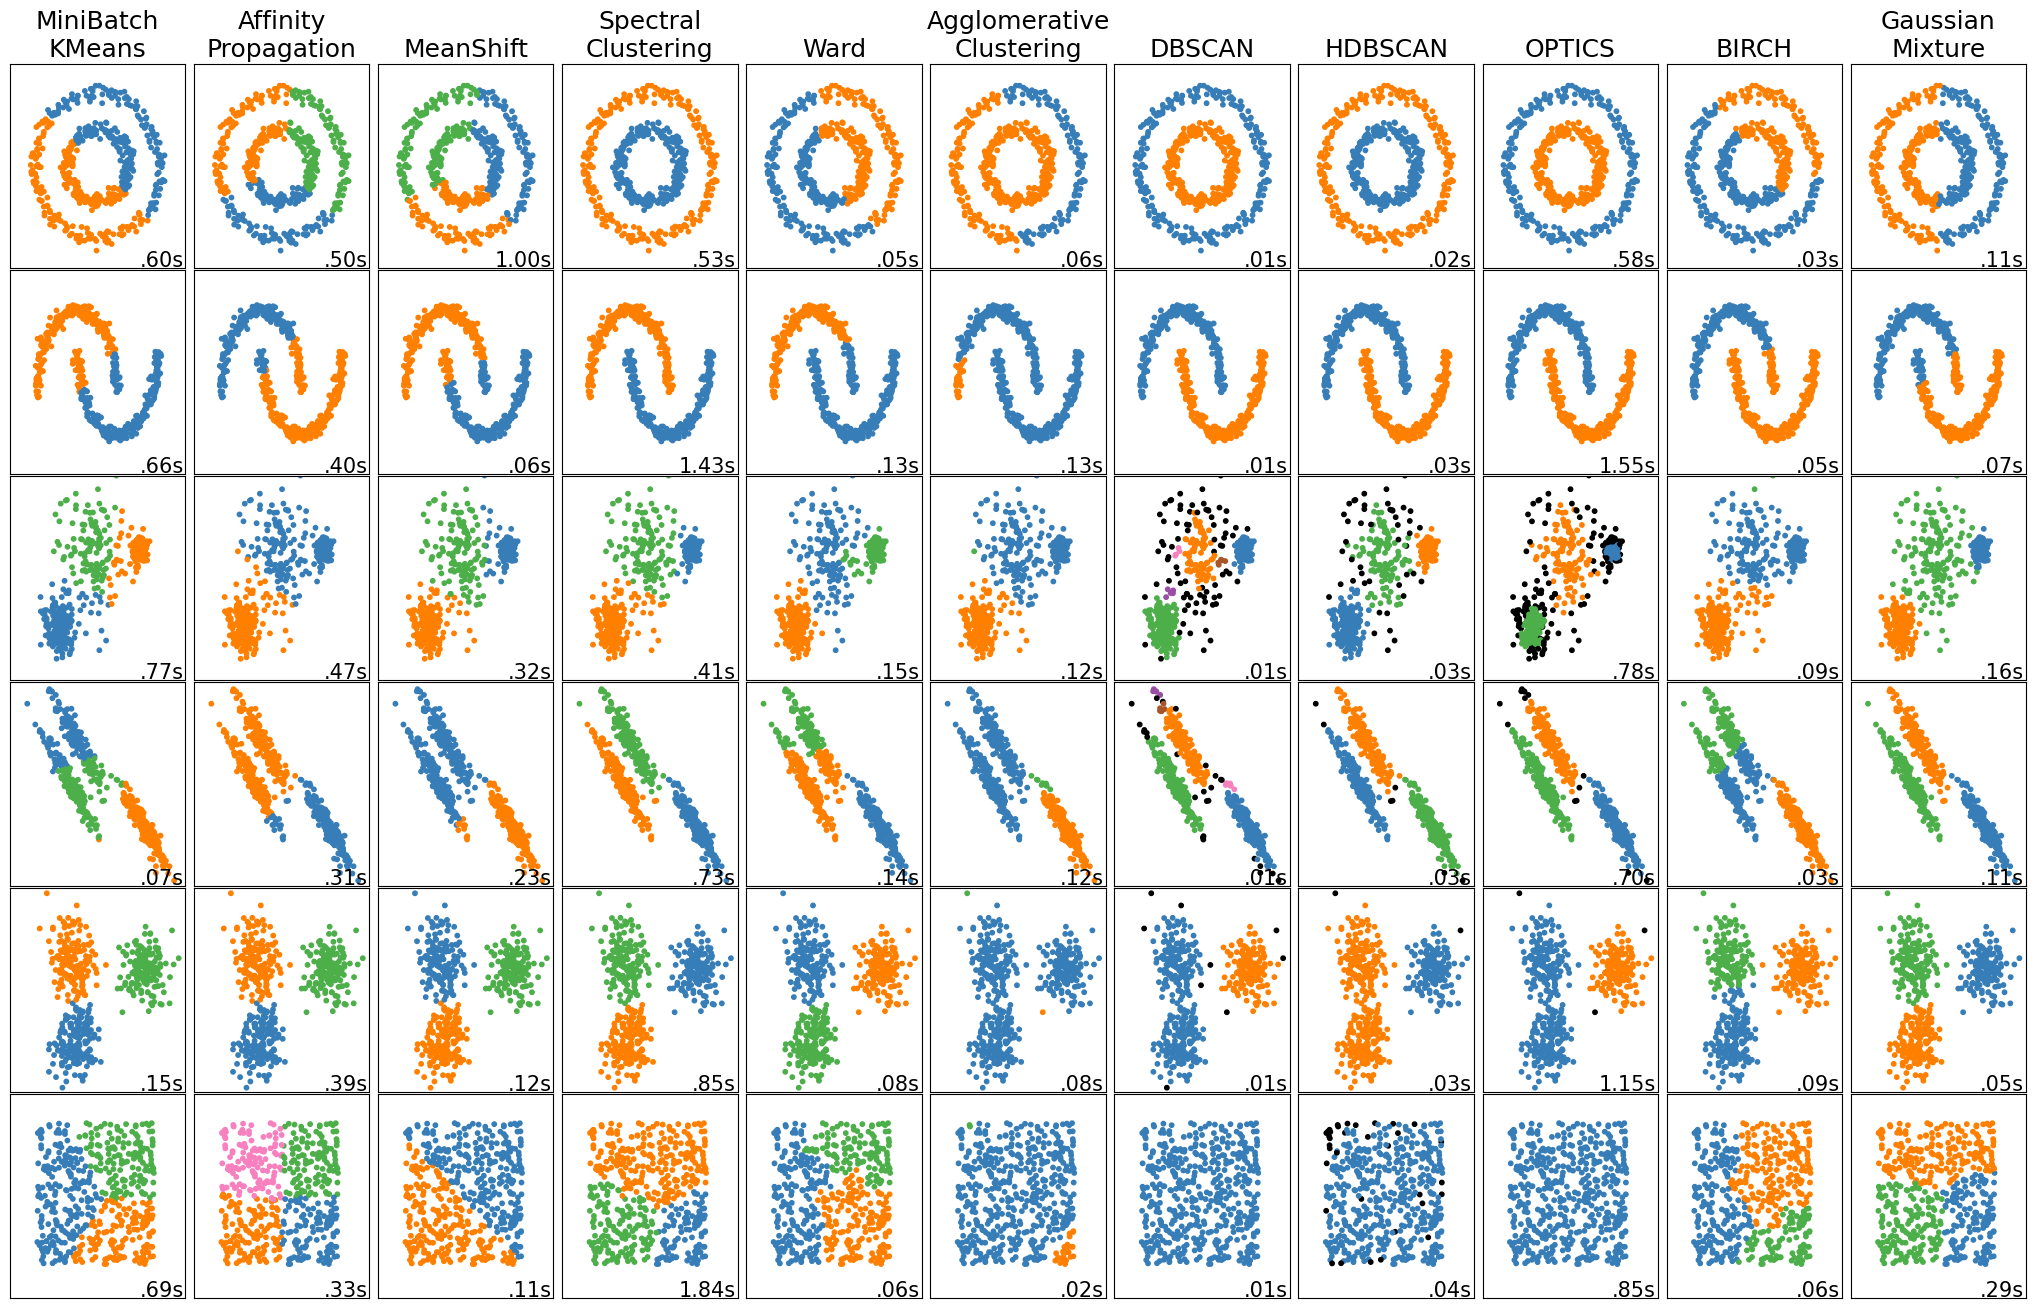

In [ ]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()